Define the participant, model, and directories

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

# Configuration
PARTICIPANT = 65  # Change this to the desired participant number
MODEL_PATH = 'saved_models/skeptic_v10/skeptic_v10.pth'  # Change this to the desired model path
TEST_DIGITS_FOLDER = 'test_digits'

# Construct the zip filename based on the participant number
ZIP_FILENAME = f'experiment_results_participant{PARTICIPANT}.zip'
ZIP_FILEPATH = os.path.join(TEST_DIGITS_FOLDER, ZIP_FILENAME)

# Load the pre-trained model
from mnist_skeptic_v9 import skeptic_v9  # Ensure this import works

model = skeptic_v9()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

C:\Users\Sai\AppData\Local\Temp\ipykernel_38968\1836490621.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


skeptic_v9(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Define any helper functions here

In [2]:
def extract_images(zip_filepath, participant):
    extracted_images = {}
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        composite_images = [f for f in file_list if f.endswith(f'_composite_participant{participant}.png')]
        for image_name in composite_images:
            with zip_ref.open(image_name) as file:
                img = Image.open(file)
                img_array = np.array(img)
                digit = int(image_name.split('_')[0])
                extracted_images[digit] = img_array
    return extracted_images

def display_images(images, title):
    plt.figure(figsize=(15, 8))
    for i, (digit, img_array) in enumerate(sorted(images.items())):
        plt.subplot(2, 5, i+1)
        plt.imshow(img_array, cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def preprocess_image(img_array):
    if len(img_array.shape) == 3:
        if img_array.shape[2] == 4:  # RGBA image
            img_array = img_array[:,:,0]  # Take only the first channel
        else:
            img_array = np.mean(img_array, axis=-1)
    
    if img_array.shape != (16, 16):
        raise ValueError(f"Unexpected image shape: {img_array.shape}")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img_tensor = transform(Image.fromarray(img_array.astype('uint8')))
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

def evaluate_model(model, images, participant):
    results = {}
    for true_label, img_array in images.items():
        try:
            processed_img = preprocess_image(img_array)
            with torch.no_grad():
                prediction = model(processed_img)
            probabilities = torch.nn.functional.softmax(prediction, dim=1)
            predicted_label = torch.argmax(probabilities).item()
            confidence = probabilities[0, predicted_label].item()
            results[true_label] = {
                'predicted_label': predicted_label,
                'confidence': confidence,
                'image': img_array
            }
        except Exception as e:
            print(f"Error processing digit {true_label}: {str(e)}")
    return results

def display_results(results):
    plt.figure(figsize=(20, 10))
    for i, (true_label, data) in enumerate(sorted(results.items())):
        plt.subplot(2, 5, i+1)
        plt.imshow(data['image'], cmap='gray')
        plt.title(f"True: {true_label}, Pred: {data['predicted_label']}\nConf: {data['confidence']:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nDetailed Results:")
    print("True Label | Predicted Label | Confidence")
    print("-" * 45)
    for true_label, data in sorted(results.items()):
        print(f"{true_label:^10} | {data['predicted_label']:^15} | {data['confidence']:^10.2f}")

    accuracy = sum(1 for true_label, data in results.items() if true_label == data['predicted_label']) / len(results)
    avg_confidence = sum(data['confidence'] for data in results.values()) / len(results)
    print(f"\nOverall Accuracy: {accuracy:.2f}")
    print(f"Average Confidence: {avg_confidence:.2f}")

Run the pipeline

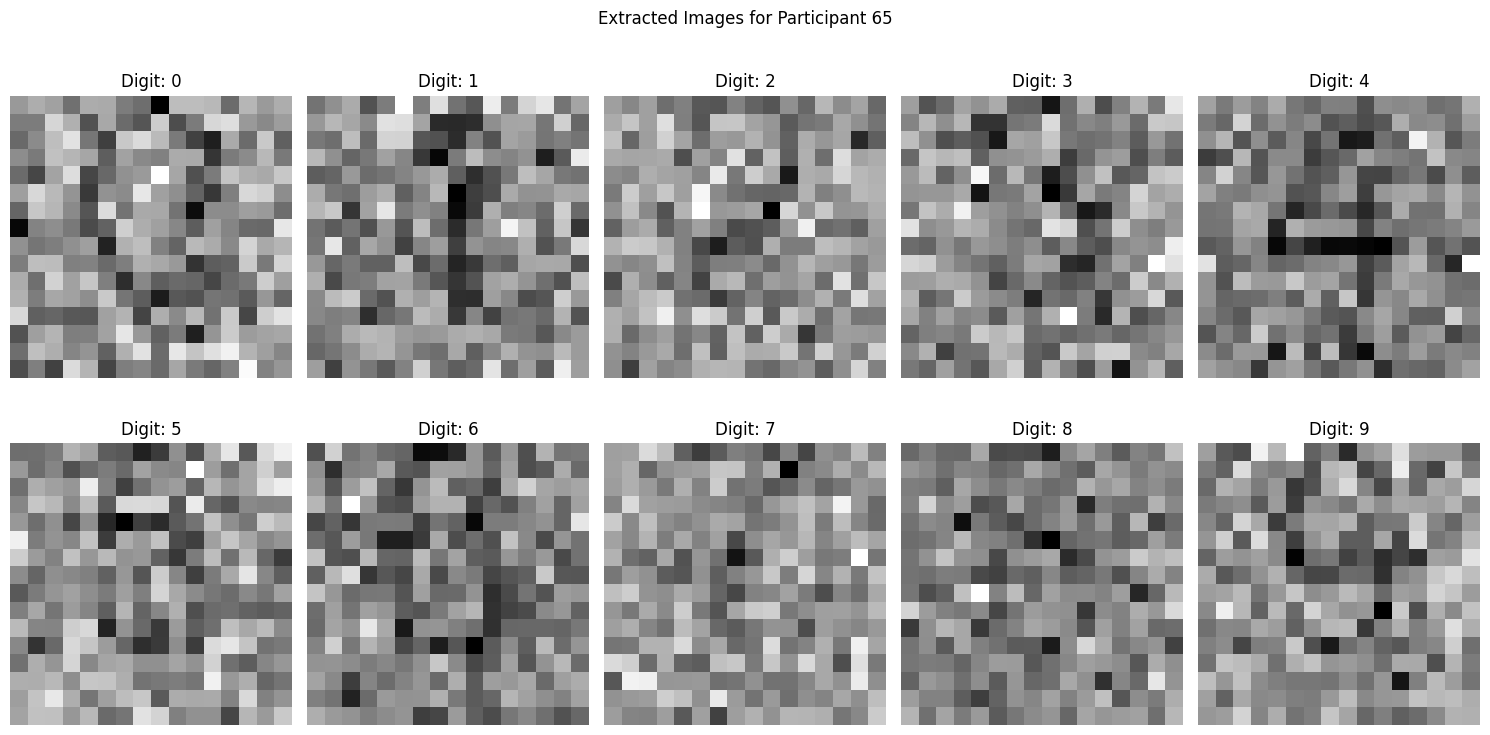

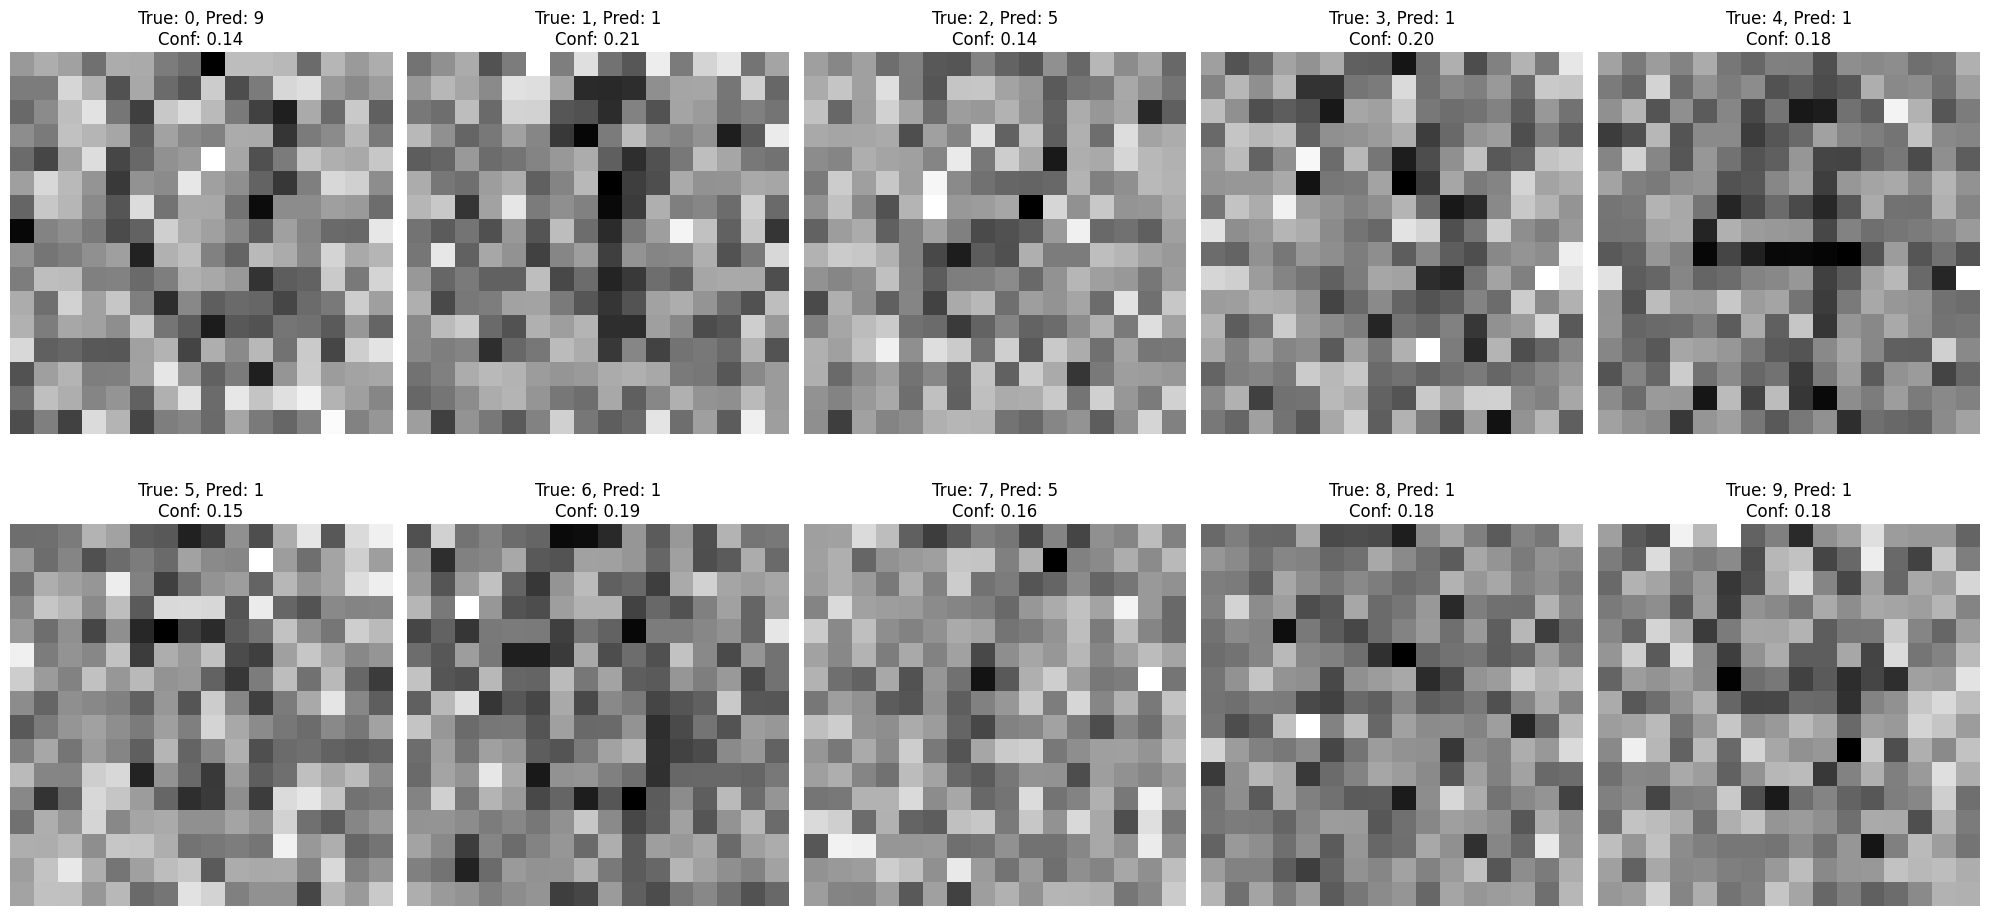


Detailed Results:
True Label | Predicted Label | Confidence
---------------------------------------------
    0      |        9        |    0.14   
    1      |        1        |    0.21   
    2      |        5        |    0.14   
    3      |        1        |    0.20   
    4      |        1        |    0.18   
    5      |        1        |    0.15   
    6      |        1        |    0.19   
    7      |        5        |    0.16   
    8      |        1        |    0.18   
    9      |        1        |    0.18   

Overall Accuracy: 0.10
Average Confidence: 0.17


In [3]:
# Extract images
extracted_images = extract_images(ZIP_FILEPATH, PARTICIPANT)

# Display extracted images
display_images(extracted_images, f"Extracted Images for Participant {PARTICIPANT}")

# Evaluate model
results = evaluate_model(model, extracted_images, PARTICIPANT)

# Display results
display_results(results)